In [1]:
# @title Google Dirveに接続
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
DRIVE_BASE_DIR = "/content/drive/MyDrive" # Myドライブの場所
os.chdir(DRIVE_BASE_DIR)

Mounted at /content/drive


In [14]:
# @title ライブラリのインストール
%cd slack-team-analyzer
!apt-get install -y graphviz libgraphviz-dev
!pip install -r requirements.txt

/content/drive/MyDrive/slack-team-analyzer


In [66]:
# @title ベクトル化
%env USE_LOCAL_LLM=True
!python embedding_user.py -f user_messages.db

/usr/local/lib/python3.10/dist-packages/jax/_src/cloud_tpu_init.py:73: UserWarning: JAX_USE_PJRT_C_API_ON_TPU no longer has an effect (the new TPU runtime is always enabled now). Unset the environment variable to disable this warning.
  warnings.warn(
100% 808/808 [14:23<00:00,  1.07s/it]
Total token size: 82588
Total cost: 0.0017 USD


100%|██████████| 808/808 [00:00<00:00, 1679.84it/s]


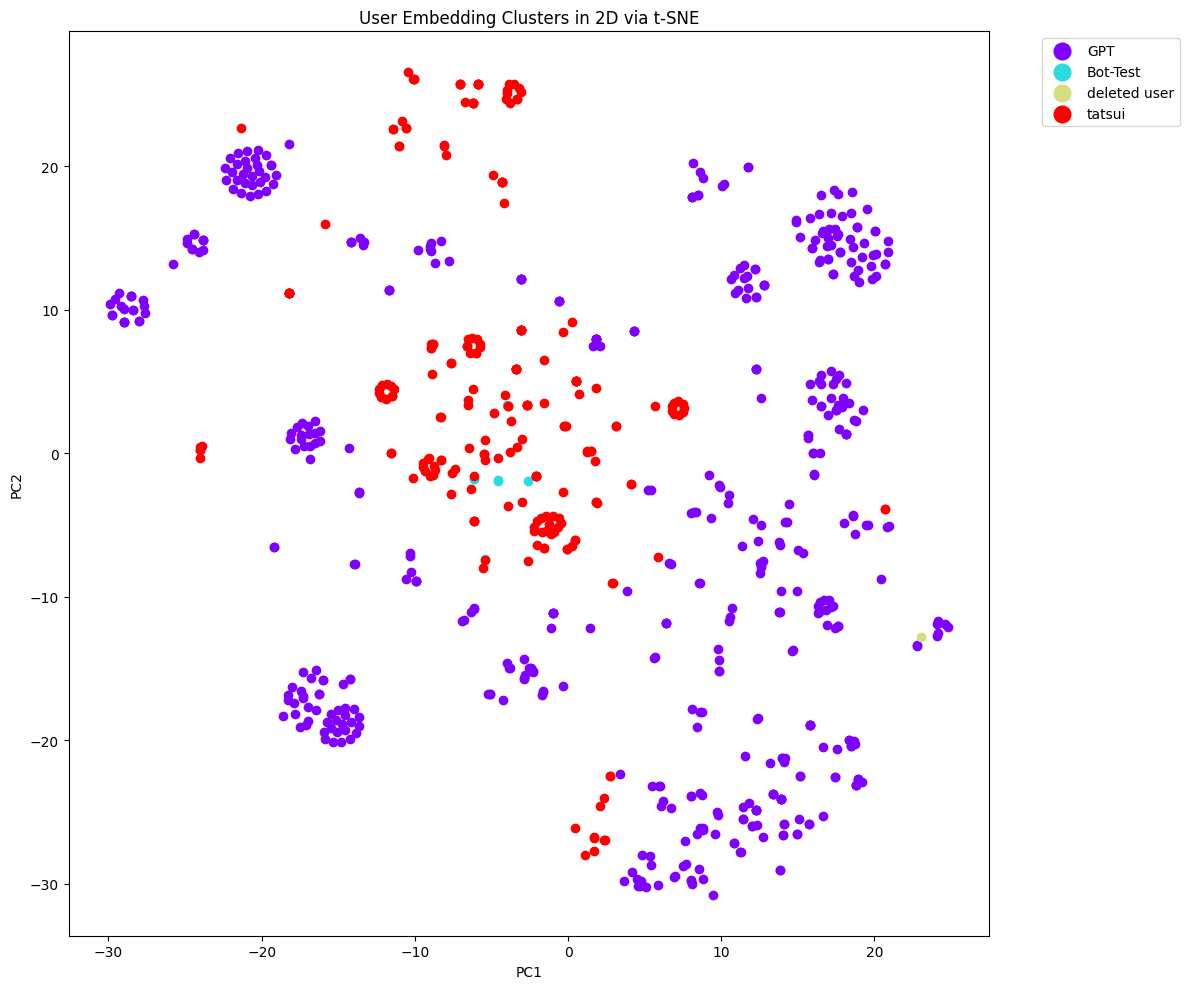

Total token size: 0
Total cost: 0 USD


In [71]:
# @title メッセージのグループを可視化
import os
import json
import time
from tqdm import tqdm
from analysis import get_messages
from embedding import plot_embeddings
from slack_sdk import WebClient

slack_token = "" # @param {type:"string"}
# Slackクライアントの初期化
client = WebClient(token=slack_token)

def get_user_info(user_id):
    user_info = client.users_info(user=user_id)
    return user_info

def plot(db_file, user, skip_bot):
    total_cost = 0
    total_token_size = 0
    embeddings = []
    real_name_cache = {}
    messages = get_messages(db_file, user_id=user, channel_id=None)
    for message in tqdm(messages):
        if skip_bot and "bot_id" in message:
            continue
        embedding = message.get("embedding")
        # view embeddings
        if embedding is not None:
            user_id = message["user"]
            if real_name_cache.get(user_id) is None:
                user_info = get_user_info(user_id)
                if user_info["user"]["deleted"]:
                    real_name_cache[user_id] = "deleted user"
                else:
                    real_name_cache[user_id] = user_info["user"]["profile"]["real_name"]
            real_name = real_name_cache[user_id]
            embeddings.append({"user": real_name, "values": embedding})

    plot_embeddings(embeddings)

    print(f"Total token size: {total_token_size}")
    print(f"Total cost: {round(total_cost, 4)} USD")

plot(db_file="user_messages.db", user=None, skip_bot=False)